# ML Design Pattern: Repeatable Splitting


## Reproducible ML: Maybe you shouldn't be using train_test_split

Reproducibility is critical for robust data science -- after all, it is a science.

But reproducibility in ML can be surprisingly difficult. 

**The behaviour of your model doesn't only depend on your code, but also the underlying dataset that was used to train it**

Therefore, you need to keep tight control on which datapoints were used to train and test your model to ensure reproducibility.

A fundamental tenet of the ML workflow is splitting your data into training and testing sets. This involves deliberately withholding some datapoints from the model training in order to evaluate the performance of your model on 'unseen' data.

It is vitally important to be able to reproducibly split your data across different training runs. For a few main reasons:
- So you can use the same test datapoints to effectively compare the performance of different model candidates
- To control as many variables as possible to help troubleshoot performance issues
- To ensure that you, or your colleagues, can reproduce your model exactly

**How you split your data can have a big effect on the perceived model performance**

If you split your data 'randomly' there is a statistical chance that more outliers end up in the test set than the training set. As your model won't see many outliers during training, it will perform poorly on the test set when predicting 'outlier' values. 

Now imagine you randomly split the data again and the outliers now all reside in the training set and none in the test set. It is likely that your 'model performance' will increase. This performance increase has nothing to do with the model, just the statistical properties of the training/test sets.

It is important to control and understand the training and test splits when comparing different model candidates and across multiple training runs.

**Sklearn train_test_split**
 
Probably, the most common way to split your dataset is to use Sklearn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

Out of the box, the `train_test_split` function will randomly split your data into a training set and a test set. Each time you run the function you will get a different split for your data. Not ideal for reproducibility.

"Ah!" you say. "I set the random seed so it is reproducible!". 

Fair point. Setting random seeds is certainly an excellent idea and goes a long way to improve reproducibility. I would highly recommend setting random seeds for any functions which have non-deterministic outputs. 

**However, random seeds might not be enough to ensure reproducibility** 

In this post I will demonstrate that the `train_test_split` function is more sensitive than you might think, and explain why using a random seed does not always guarantee reproducibility, particularly if you need to retrain your model in the future.

## What is the problem with train_test_split?

**Setting the random reed only guarantees reproducible splits if the underlying data does not change in any way**

The `train_test_split` is not *deterministic*. 

The splits from `train_test_split` are sensitive to any new data added to the dataset as well as the *ordering* of the underlying data.

If your dataset is shuffled or amended in any way, the data will be split completely differently. It cannot be guaranteed that the an individual datapoint will *always* be in the training set or *always* be in the test set. This means datapoints that were in the original training set might now end up in the test set and visa versa if the data was shuffled. 

**Therefore, for the same dataset, you can get different splits depending on how the rows in the dataset are ordered.** 

It is not a very robust solution. 

Even if one datapoint is removed, the order of two rows are switched, or a single datapoint is added you will get a *completely* different training and test split.

This 'ultra sensitivity' to the data might be surprising and lead to unexpected model training results which can be hard to debug and reproduce if your dataset ordering changes.

Let's demonstrate the issue with a simple demo.

We will first download an example dataset from `skelearn.datasets` and create an 'index' column to uniquely identify each row.

In [1]:
from sklearn.datasets import load_breast_cancer

import pandas as pd

# download an example dataset
data = load_breast_cancer()
df = pd.DataFrame(data["data"], columns=data["feature_names"])

# create an 'index' column to use to uniquely identify each row
df = df.reset_index(drop=False)

df.head()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Now let's split the data using Sklearn's `train_test_split`, setting the random state (seed).

In [2]:
from sklearn.model_selection import train_test_split

TEST_RATIO = 0.1
SEED = 42

# split into training and test using a random seed
x_train_skl, x_test_skl = train_test_split(df, test_size=TEST_RATIO, random_state=SEED)

Next, we shuffle the original dataframe and split the data again. We will still use the same random seed as before for consistency.

Note that no new data has been added, we have just reordered the rows. 

In [3]:
# shuffle the orginal dataframe
df_shuffled = df.sample(frac=1)

# split the shuffled dataframe using the same random seed
x_train_skl_shuffled, x_test_skl_shuffled = train_test_split(
    df_shuffled, test_size=TEST_RATIO, random_state=SEED
)

Ideally the rows contained in the `x_test_skl` and `x_test_skl_shuffled` test sets should be identical as we used the same random seed. 

However, when we compare the row ids contained in each test set, we notice they are different! Even though the random state (seed) was the same both times. Nothing in the data has changed, it was just shuffled.

In [4]:
# compare the row ids included in the original test set vs shuffled test set
# should return True if identical rows are included in each test set
set(x_test_skl["index"]) == set(x_test_skl_shuffled["index"])

False

This highlights just how sensitive the `train_test_split` function is, even to ordering of the data.

More importantly, if there was a change in the underlying data, such as a reordering, which resulted in different splits, it would be extremely difficult to reproduce the original data splits and debug model performance.

I was certainly surprised by how sensitive this function was to something as trivial as the ordering of the underlying dataset.

## What are the consequences of relying on a random seed when retraining the model with updated data?

As mentioned previously, the results of your model can vary significantly depending on how the data was split.

In the future, when you come to retrain your model with some updated data you want to be able to control as many variables as possible in order to effectively compare the accuracy and performance of each model.

**You cannot guarantee reproducibility and transparency of splits with random seed**

It is be risky relying on a random seed from a reproducibility point of view.

The random seed only guarantees reproducibility when the dataset has not changed in any way.

Can you be 100% sure the dataset has not changed between training runs? If a colleague has removed an outlier data point or if new rows have been added. Your data splits will be completely different to your original splits with no way to easily replicate the old data splits.

You can use data versioning tools, such as [dvc](https://dvc.org/) to help keep track of changes, however, that doesn't prevent your data splits changing. It would be better to protect against split changes in your code.

Additionally, the process of splitting by the `train_test_split` function is not very transparent. It is non-deterministic. This means the same datapoint can be split differently and it is not clear why it appears in the training set one time and in the testing set the next.

The lack of transparency makes it hard to understand or predict which split the datapoint will be placed. Now or in the future.

**Difficult to effectively compare models**

When comparing models, we want to be able to control as many variables as possible. That should include which datapoints were used for training and testing.

If your data splits are significantly different between runs you might observe considerable differences in performance. For example if you have a couple of 'outlier' datapoints  that were in your training set for the original training run, but are now in your test set, you model performance might 'decline' as it could not predict outlier values in the test set as well as before.

**Difficult to debug**

If you can't effectively compare models, it can make it hard to debug performance issues.

Imagine you add some new data points to your dataset and retrain your model, but the performance of the model drops.

If you have used `train_test_split` with the random seed set, you will have completely different data splits as the underlying data has changed. It would be difficult to understand whether the model performance decline was due to the quality of the new data, or, as highlighted in the previous point, it was just because the data was split differently. So the model performance decline was due to statistical variation in the way the data was split.

## When might train_test_split not be appropriate?

**If you need to retrain your model in the future on the original data + new data**

As demonstrated, any underlying change to your existing data, be it reordering or even adding one additional datapoint will cause completely different data splits. Your original data splits will not be reproducible.

If you are retraining the model with a *completely* new dataset it isn't a problem as obviously all the training and test datapoints will be different.

But if you are training again with a dataset that includes your original datapoints, ideally you should be able to replicate their original data splits during the new training run. Even with the random seed set, `train_test_split` will not guarantee this. 


**If you are sampling or retrieving your source data from an evolving data source**

In an ideal situation, you should have full control of your source dataset, however, sometimes this is not the case.

For example, if you are using a table stored in BigQuery as the source which is used be many teams. You cannot guarantee the order of the rows returned by a query and new rows might be appended to the table in the meantime.

Another example, would be if you are working with image data stored in a filesystem. If new images are added to your source folder you cannot guarantee the ordering of filepaths especially if new images are added.

**If there is a possibility of data leakage**

Imagine you are working with a dataset containing information about airline arrival times and you want to predict the chances of a plane arriving late. 

It is likely that rows of data at the same date will be correlated with each other. If we randomly split the data we risk data leakage. Therefore, we want a method to split the data such that datapoints at the same date only end up int the training set, or only end up in the test set.

`train_test_split` does not allow for splitting the data based on a particular column value.
  
**If you have large datasets which do not fit in memory**

If you need to distribute your data across many machines in order to parallelise data processing, using a non-deterministic method for splitting your training and test data can be problematic and difficult to ensure reproducibility.


**If your experimentation or production code will be rewritten in another language**

As the `train_test_split` is non-deterministic, the data splits will not be easily reproducible across languages. 

For example, you might want to compare the performance of your custom Python model to a model created using BigQuery's BQML which is defined using SQL. The splits from `train_test_split` Sklearn will not easily translate directly to SQL.

It can also be common for teams to prototype models using Python, but then write their production systems in another language such as Java. To help the process of translating the prototype model into another language, ideally we should be able to split the data in the same way in both languages to ensure reproducibility and help debug any differences from the original model to the new model.

## The Solution: Hashing

### What is hashing?

> "A hash function is any function that can be used to map data of arbitrary size to fixed-size values" [Wikipedia](https://en.wikipedia.org/wiki/Hash_function)

There are many different hashing algorithms, but essentially they allow you to reproducibly convert an input into an arbitrary value.

The output of the hashing function is deterministic -- it will always be the same for the same input.


### How does it work for splitting data reproducibly?

In the context of data splitting, we can use hashing to reliably assign splits to individual datapoints. As this is a deterministic process, we can ensure that the datapoint is always assigned to the same split which aids reproducibility.

The process works as follows:
- Use a unique identifier for the datapoint (e.g. an ID or by concatenating multiple columns) and use a hashing algorithm to convert it to an arbitrary integer. Each unique datapoint will have a unique output from the hashing function.
- Use a [modulo operation](https://en.wikipedia.org/wiki/Modulo_operation) to arbitrarily split the data into 'buckets'
- Select all datapoints in a subset of buckets to be the training set and the rest to be in the test set

```
# example pseudo code

id = "0001"

# convert id into a hashed integer value
hash_value = hash(id)

# assign a bucket between 0 and 9
bucket = hash_value % 10

# add id to train set if less than 9 (i.e. approx 90% of the data)
if bucket < 9:
   train_set.append(id)
else:
   test_set.append(id)
```


### Reasons to use hashing

**Deterministic**

Hashing is robust to underlying changes in the data, unlike `train_test_split`.

Using this method, an individual datapoint will *always* be assigned to the same bucket. If the data is reordered or new data is added, the assigned bucket will not change. This is preferable as a datapoint's train/test split assignment is now independent of the rest of the dataset. 

**Improves development and reduces chances of human error**

When working on models in parallel with colleagues, it is very easy to accidentally forget to use random seeds or even use different random seeds. This leaves you open the risk of human error.

Using the same hashing algorithm removes the need to control reproducibility explicitly in your code with random seeds. As long as you agree with your team on which hashing algorithm to use you will always recreate the same splits. No risk of human error.  

**Consistent splitting across raw and preprocessed data**

During experimentation you might investigate different preprocessing steps and save intermediate and preprocessed data in a new file. You then might load this intermediate data at another stage to continue your analysis.

As the preprocessed data is different to the raw data, using `train_test_split` and random seeds will give different splits for the raw and preprocessed data when loaded from a new file.

Hashing will provide identical splits for raw and preprocessed data as long as the column used for calculating the hash value has not changed.

**Storage and memory efficient**

There are other strategies to combat reproducibility (discussed later in this article) such as explicitly saving data in a 'training' file and a 'test' file or adding a new column to your data to indicate which train/test split the datapoint belongs to.

However, sometimes you are not able to save data to new files and add columns  -- for example, if you don't have permissions to copy or edit the original datasource or the data is too large.

Hashing is deterministic and the datapoint split can be calculated 'on the fly' in memory when required without needing to explicitly change the underlying data or save into a new file.

### Farmhash

There are [many different hashing algorithms](https://en.wikipedia.org/wiki/List_of_hash_functions) which are used for multiple use cases such as checksums and cryptography.

For the purpose of creating reproducible train/test splitting we need to use a 'fingerprint' hash function. [Fingerprint hash functions](https://devopedia.org/fingerprinting-algorithms) are lightweight, efficient and deterministic -- they will always return the same value for the same input.

Cryptographic hash functions, such as MD5 and SHA1, are not suitable for this use case as they are not deterministic and they are also purposefully made to be computationally expensive.

[Farmhash is developed by Google](https://github.com/google/farmhash) and [recommended for this use case](https://towardsdatascience.com/ml-design-pattern-5-repeatable-sampling-c0ccb2889f39). It has a simple [Python library](https://pypi.org/project/pyfarmhash/) implementation and is available across many other languages including [BigQuery SQL](https://towardsdatascience.com/ml-design-pattern-5-repeatable-sampling-c0ccb2889f39). 

> Another alternative to Farmhash is to use zlib and the crc32 chechsum algorithm. An example of the implementation is shown in this notebook from [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)

Below is a demo of farmhash and how we can use it to assign buckets to our datapoints.

In [5]:
# install Python library
# ! pip install pyfarmhash

Let's start by converting an individual ID into a hashed integer value using farmhash's `fingerprint64` function.

In [6]:
import farmhash

example_id = "0001"
hashed_value = farmhash.fingerprint64(example_id)
print(hashed_value)

6241004678967340495


We can now assign this datapoint to a 'bucket' using an arbitrary function. 

A useful method for this can be to use the modulo function. The integer outputs from the hashing algorithm are randomly distributed, therefore using the modulo function with a divisor of 10, for example, will split the data into 10 random buckets (from 0 to 9).

In [7]:
# assign a bucket using the modulo operation
bucket = hashed_value % 10
print(bucket)

5


Therefore, our datapoint ID of "0001" would be assigned to bucket 5. 

### Splitting the dataset using Farmhash

Now let's apply this splitting strategy to our dataset.

The `hash_train_test_split` function below can be used to split a dataframe into training and test sets using a specified hash function. In this example, the function creates a new column to store the bucket assignments. This is just for demonstration purposes, there is no need to actually store the bucket values in your data.

I have broken each step of the process into an individual functions. This is so we decouple the hashing function and test set checking functions from the main function. This allows us to swap different hash functions or test set checking functions as required.

In [8]:
from typing import Any, Callable

TEST_RATIO = 0.1
BUCKETS = 10

# define some custom types (optional)
HashFunc = Callable[[Any], int]
TestSetCheckFunc = Callable[[int], bool]


def generate_farmhash_fingerprint(value: Any) -> int:
    """Convert a value into a hashed value using farmhash"""
    return farmhash.fingerprint64(str(value))


def convert_hash_to_bucket(hashed_value: int, total_buckets: int) -> int:
    """Assign a bucket using modulo operator"""
    return hashed_value % total_buckets


def test_set_check(bucket: int) -> bool:
    """Check if the bucket should be included in the test set

    This is an arbirtary function, you could change this for your own
    requirements

    In this case, the datapoint is assigned to the test set if the bucket
    number is less than the test ratio x total buckets.
    """
    return bucket < TEST_RATIO * BUCKETS


def assign_hash_bucket(value: Any, hash_func: Callable) -> int:
    """Assign a bucket to an input value using hashing algorithm"""
    hashed_value = hash_func(value)
    bucket = convert_hash_to_bucket(hashed_value, total_buckets=BUCKETS)
    return bucket


def hash_train_test_split(
    df: pd.DataFrame,
    split_col: str,
    approx_test_ratio: float,
    hash_func: HashFunc,
    test_set_check_func: TestSetCheckFunc,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Split the data into a training and test set based of a specific column

    This function adds an additional column to the dataframe. This is for
    demonstration purposes and is not required. The test set check could all
    be completed in memory by adapting the test_set_check_func

    Args:
        df (pd.DataFrame): original dataset
        split_col: name of the column to use for hashing which uniquely
            identifies a datapoint
        approx_test_ratio: float between 0-1. This is an approximate ratio as
            the hashing algo will not necessarily provide a uniform bucket
            distribution for small datasets
        hash_func: hash function to use to encode the data
        test_set_check_func: function used to check if the bucket should be
            included in the test set
    Returns:
        tuple: Two dataframes, the first is the training set and the second
            is the test set
    """

    # assign bucket
    df["bucket"] = df[split_col].apply(assign_hash_bucket, hash_func=hash_func)

    # generate 'mask' of boolean values which define the train/test split
    in_test_set = df["bucket"].apply(test_set_check_func)
    return df[~in_test_set], df[in_test_set]

As before, we will create a train/test split using the original breast cancer dataset, but use the hashing method with Farmhash instead of sklearn's `train_test_split` with random seeds. 

Then we will shuffle the data, split the data again and compare the test set ID's to ensure the splits are the same.

In [9]:
# create a training and test set from original dataset using hashing method
x_train_hash, x_test_hash = hash_train_test_split(
    df,
    split_col="index",
    approx_test_ratio=TEST_RATIO,
    hash_func=generate_farmhash_fingerprint,
    test_set_check_func=test_set_check,
)


# create a training and test set from shuffled dataset using hashing method
x_train_hash_shuffled, x_test_hash_shuffled = hash_train_test_split(
    df_shuffled,
    split_col="index",
    approx_test_ratio=TEST_RATIO,
    hash_func=generate_farmhash_fingerprint,
    test_set_check_func=test_set_check,
)

In [10]:
# show which bucket each row has been assigned for demo purposes
x_train_hash[["index", "bucket"]].head()

,index,bucket
0,0,5
1,1,9
2,2,9
3,3,1
4,4,3


In [11]:
# compare the row ids included in each test set
set(x_test_hash["index"]) == set(x_test_hash_shuffled["index"])

True

Problem solved! Even though the underlying dataframe is shuffled, the same row ids appear in the test dataset regardless.

## Considerations

This method is a little (although not much) more complicated than the common Sklearn `train_test_split`, and there are some additional things to think about when implementing this approach.

**Hashing will not split your data exactly according to your specified train/test ratio**

The output integers from the hashing algorithm are consistent but still random. By statistical chance, you may have slightly more outputs assigned to a particular bucket which means you might not get *exactly* 10% of your data being assigned to the test set. It might be slightly more or less. This is why I named the argument in the function 'approx_test_ratio' as the result will only be approximately that ratio.

In our example above, we specified a ratio of 0.1 and would expect from a dataset size of 56. However, we actually ended up with on 46 records in the test set (8%).

In [12]:
total_records = len(df)
target_records = int(total_records * TEST_RATIO)
hash_test_set_records = len(x_test_hash)
actual_ratio = round(hash_test_set_records / total_records, 2)

target_records, hash_test_set_records, actual_ratio

(56, 46, 0.08)

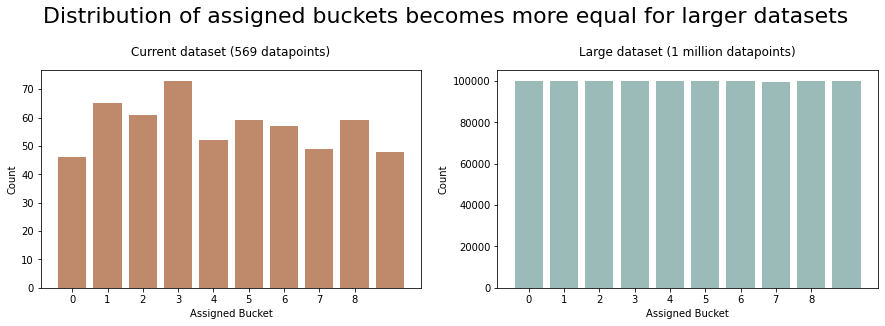

In [13]:
import matplotlib.pyplot as plt
import numpy as np


def plot_bucket_distributions(
    ax, buckets: list[int], title: str, bar_color: str
) -> None:
    ax.bar(*np.unique(buckets, return_counts=True), color=bar_color)
    ax.set_xticks(range(max(buckets)))
    ax.set_xlabel("Assigned Bucket")
    ax.set_ylabel("Count")
    ax.set_title(title, pad=15)


# create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# our example
demo_example = x_train_hash["bucket"].tolist() + x_test_hash["bucket"].tolist()
plot_bucket_distributions(
    ax1,
    demo_example,
    title="Current dataset (569 datapoints)",
    bar_color="#BF8A6C",
)


# large dataset example
bigger_example = [farmhash.fingerprint64(str(i)) % 10 for i in range(1_000_000)]
plot_bucket_distributions(
    ax2,
    bigger_example,
    title="Large dataset (1 million datapoints)",
    bar_color="#9ABBB7",
)

plt.suptitle(
    "Distribution of assigned buckets becomes more equal for larger datasets",
    fontsize=22,
    y=1.1,
)
plt.show()

The larger your dataset, the more uniform the bucket assignments will be and the closer to your desired ratio the splits will become (law of large numbers).

Generally this should not be a problem though. Using a 90:10 train/test split is arbitrary. In reality, it doesn't matter if your split is a little over or under this target ratio.


**How many buckets should you choose**

I.e. which number should you use as the divisor for the modulus operation.

This really depends on granularity of the desired test split. If you want to have a split of 90:10 you can split your data into 10 buckets using '10' as the divisor. Then choose one of the buckets to be your test set which will be approximately 10% of your datapoints. 

If you want 15% of your data for testing, you could use `100` as the divisor to split the data into 100 buckets. You could randomly choose 15 buckets from your data to get 15% of your data for testing. 

**Platform cross-compatibility quirks**

Having said that hashing is consistent across platforms. That is true to an extent.

While researching for this article, I tested to see if the dataset splits from my Python program were identical to a dataset stored in [BigQuery using SQL instead](https://towardsdatascience.com/ml-design-pattern-5-repeatable-sampling-c0ccb2889f39).

To my surprise, I found some edge cases where the results differed.

After a lot of head scratching, I came across a two quirks of BigQuery which were causing the issue:
1. [BigQuery does not support unsigned integers](https://stackoverflow.com/questions/51892989/how-does-bigquerys-farm-fingerprint-represent-a-64-bit-unsigned-int)
2. BigQuery, [C and C++ have different implementations for the modulus operation](https://stackoverflow.com/questions/3883004/the-modulo-operation-on-negative-numbers-in-python) compared to Python when it comes to negative numbers

The `farmhash.fingerprint64` method returns an *[unsigned](https://stackoverflow.com/questions/247873/signed-versus-unsigned-integers)* integer. Whereas the BigQuery `FARM_FINGERPRINT` function returns a `INT64` datatype. Therefore, BigQuery converts the farmhash output to a *signed* integer. The value of signed integer might be different to the original unsigned integer value and it might be negative.

Ok, can't we just convert our Python farmhash value to a signed integer?

Well, this leads to the second problem. In order to split the data into different buckets, we used the modulus operation. [Python and C (and BigQuery) have different implementations of the modulus operator](https://stackoverflow.com/questions/1907565/c-and-python-different-behaviour-of-the-modulo-operation#:~:text=Both%20variants%20are%20correct%2C%20however,same%20result%20as%20in%20Python.) which affects the results for negative numbers.

Therefore, if our signed integer is negative, the bucket it is assigned will differ depending on if we calculated it using Python's modulus operator (`%`) or BigQuery's `MOD` function. 

> Note: this is nothing to do with the hash function or approach. This is to do with how different languages deal with unsigned integers and the modulus of negative numbers

For example:

```
# in python
-1%10 = 9

# in BigQuery
MOD(-1,10) = -1
```

Does this mean hashing is not platform independent? 

Well, not really, just that you need to check how unsigned integers are treated and the how modulus of negative numbers is implemented.

We can fix our Python implementation to protect against these issues by converting the unsigned output of farmhash to a signed int and using a custom 'C-like' implementation of the modulus function.

```python
import numpy as np

def signed_hash_value(value:Any) -> int:
    """Calculate hash and convert unsigned int to a signed int"""
    hashed_value = farmhash.fingerprint64(str(value))
    return np.uint64(hashed_value).astype("int64")
    
def c_mod(a:int, b:int)->int:
    """Modulus function implemented to behave like 'C' languages"""
    res = a % b
    if a < 0:
        res -= b
    return res

# this will give the same results in Python and BigQuery (and C-languages)
assigned_bucket = abs(c_mod(signed_hash_value,10))
```

> Note: [the order of the abs and mod functions is important](https://mentin.medium.com/be-careful-with-abs-function-8e91c78715d5)
>
> See this [StackOverflow thread](https://stackoverflow.com/questions/63341637/python-vs-bigquery-farmhash-sometimes-do-not-equal) for more information


## Alternatives to hashing

For completeness, here are two other common and more explicit approaches for ensuring consistent train/test splitting. 

**Create an additional column in your data**

You could use `train_test_split` (or another random splitting method) to initially define the splits. Then create an additional column in your dataset to explicitly record whether the datapoint should be included for training or test (or specify the fold for K-Fold validation).

Here is an [example implementation by Abhishek Thakur](https://github.com/abhishekkrthakur/mlframework/blob/master/src/create_folds.py) who uses it to define the 'folds' for cross validation.

This will ensure your splits are 'remembered' between training runs as they are explicitly defined. 

On the positive side, it is very transparent which datapoints belong to each split. However, a downside is that it increases the total size of your dataset which may not be sustainable for very large datasets. Additionally, if you do not have full control of the dataset (e.g. shared database table) you may not be able to add columns to the original schema.

**Save your training and test data to different files**

Another common approach is to store your training data and test data to individual files after splitting the data for the first time. For example, into files called `train.csv` and `test.csv`. If the data is too large for individual files you could also save multiple files into folders named `train` and `test` respectively.

This can be a valid approach. However, sometimes it may not be feasible to make a copy of all your data and save into individual files. For example if the dataset size is very large or you don't have the permissions to make a copy from the original source.

The hashing approach can compute the deterministic data splits reproducibly on the fly and in-memory, preventing the need to copy data into individual files.

## Conclusion


ML is experimental and iterative, you need to be able to keep as many variables constant as possible. That includes which datapoints are used for training and which are used for testing.

- The crux, why is this important?: For reproducibility you want to ensure the data that was used to train a model remains consistent when you go to retrain it. This helps comparison of performance and debugging.
- Particularly if you need to retrain your model in the future (i.e. it is not just a one off).

## References & Resources

**Hashing**
- [ML Design Pattern: Repeatable sampling](https://towardsdatascience.com/ml-design-pattern-5-repeatable-sampling-c0ccb2889f39) (inspiration for this post)
- [Hash your data before you create the train-test split](https://www.bi-kring.nl/192-data-science/1340-reusing-data-for-ml-hash-your-data-before-you-create-the-train-test-split)

- [Farmhash Description](https://github.com/google/farmhash/blob/master/Understanding_Hash_Functions)
- [Hands on ML - different implementation](https://www.danli.org/2021/06/06/hands-on-machine-learning/) also [see notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)
- [Python Farmhash implementation](https://github.com/veelion/python-farmhash)


**Differences between Python and BigQuery**
- [Farmhash vs BigQuery implementation, GitHub issue](https://github.com/lovell/farmhash/issues/26)
- [StackOverflow question: difference in results between BigQuery and Python](https://stackoverflow.com/questions/63341637/python-vs-bigquery-farmhash-sometimes-do-not-equal)
- [BigQuery returns signed integers from FARM_FINGERPRINT function](https://stackoverflow.com/questions/51892989/how-does-bigquerys-farm-fingerprint-represent-a-64-bit-unsigned-int)
- [Be careful about operation order in BigQuery](https://mentin.medium.com/be-careful-with-abs-function-8e91c78715d5)
- [Reproducibly sampling in BigQuery](https://towardsdatascience.com/advanced-random-sampling-in-bigquery-sql-7d4483b580bb)


- [Google docs: Considerations for Hashing](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/randomization)

**Reproducibility**
https://towardsdatascience.com/reproducibility-in-data-science-c2ac9e689339

---

#### Demo of BigQuery vs Python farmhash inconsistencies

In [14]:
# example which returns negative int with bigquery
example = "1footrue"

In [15]:
# normal python method for assigning bucket
python_hash = farmhash.fingerprint64("1footrue")
print(f"Python hash: {python_hash}")

# assign to bucket
python_bucket = python_hash % 10
print(f"Python Bucket: {python_bucket}")

Python hash: 16905089972579912905
Python Bucket: 5


The result of the farmhash algo is an *unsigned* integer.

BigQuery converts unsigned integers into a signed integer. If we convert the Python unsigned integer to a signed integer, it becomes negative! This affects the bucket assignment

In [16]:
signed_int = np.uint64(python_hash).astype("int64")
print(f"Signed int: {signed_int}")

signed_int_bucket = signed_int % 10
print(f"Signed int bucket: {signed_int_bucket}")

Signed int: -1541654101129638711
Signed int bucket: 9


We can't do anything about the fact that BigQuery returns signed integers, therefore it is easiest for us to just deal with it ourselves and convert Python's farmhash values into signed ints.

However, there is a second problem. Python calculates the modulus of [negative numbers differently](http://python-history.blogspot.com/2010/08/why-pythons-integer-division-floors.html) to 'C' languages and by extension, BigQuery.

If we take the modulus of -1541654101129638711 % 10 in BigQuery we actually get -1 instead of 9 (as shown above). We can fix this in our Python code by using the following implementation:

In [17]:
def c_mod(a, b):
    res = a % b
    if a < 0:
        res -= b
    return res

In [18]:
c_mod(signed_int, 10)

-1

Ok, now one final thing.

Obviously we don't want negative numbers for our buckets -- we only what 10 buckets, not up to 20! Therefore we need to take the `abs` of the returned bucket. For example:

In [19]:
abs(c_mod(signed_int, 10))

1

So our datapoint will now be assigned to bucket 1 which will be consistent across Python and BigQuery (and C languages -- hopefully all languages, but I haven't checked...)

[Note: the order of the abs and mod functions is important](https://mentin.medium.com/be-careful-with-abs-function-8e91c78715d5)